In [1]:
#Collab bootstrapping for accessing files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#Get test_medium.csv
downloaded = drive.CreateFile({'id':"1nM4xOSa_WPF_9gmFPVMX0LgSXIduTk_X"})
downloaded.GetContentFile('test_medium.csv')

#Get train_medium.csv
downloaded = drive.CreateFile({'id':"1W5RFr2-ZKo-g3nYtPZP2k2-ePHkOKsP2"})
downloaded.GetContentFile('train_medium.csv')

In [3]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [5]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size

In [6]:
x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [7]:
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim, cell_type, cell_num):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.cell_num = cell_num
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        # Cell type check

        if cell_type == 'rnn':
            cell_fn = tf.keras.layers.SimpleRNNCell
        elif cell_type == 'gru':
            cell_fn = tf.keras.layers.GRUCell
        elif cell_type == 'lstm':
            cell_fn = tf.keras.layers.LSTMCell
        
        #Stacked RNN if needed
        cells = []
        for i in range(cell_num):
            cells.append(cell_fn(self.hidden_dim))
        cells = tf.keras.layers.StackedRNNCells(cells)
        
        #Effective RNN cell to feed the model forward
        self.rnn = tf.keras.layers.RNN(
            cells,
            unroll=True)
        #Dense layer for classification
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate):
        # forward logic
        x = self.embedding(x)
        x = self.rnn(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
    
        return logits

In [8]:
# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [9]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [10]:
#TOCHANGE
cell_type_list = ['gru','lstm','rnn'] #Experiments with lstm and rnn first for part a
cell_num = 2 #Part B
test_acc_dict = {}
train_loss_dict = {}

for rnn_cell in cell_type_list:
    print("Building %s model with %s cells"%(rnn_cell,cell_num))
    model = WordRNN(vocab_size, HIDDEN_SIZE, cell_type = rnn_cell, cell_num = cell_num)
    print("Built %s model with %s cells"%(rnn_cell,cell_num))
    #Training process
    test_acc = []
    train_entropy_loss = []
    print("Starting the training process of %s model with %s cells"%(rnn_cell, cell_num))
    for epoch in range(no_epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for word_id, labels in train_ds:
            train_step(model, word_id, labels, drop_rate=0)

        for word_id, labels in test_ds:
            test_step(model, word_id, labels, drop_rate=0)

        test_acc.append(test_accuracy.result())
        train_entropy_loss.append(train_loss.result())
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result(),
                              test_loss.result(),
                              test_accuracy.result()))
    
    #Update the result dictionary
    test_acc_dict[rnn_cell] = test_acc
    train_loss_dict[rnn_cell] = train_entropy_loss
    print("Finished training of %s model with %s cells"%(rnn_cell,cell_num))

Building gru model with 2 cells
Built gru model with 2 cells
Starting the training process of gru model with 2 cells
Epoch 1, Loss: 2.660893440246582, Accuracy: 0.07089285552501678, Test Loss: 2.6457927227020264, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6314878463745117, Accuracy: 0.08696428686380386, Test Loss: 2.4957549571990967, Test Accuracy: 0.14428570866584778
Epoch 3, Loss: 2.1212854385375977, Accuracy: 0.1882142871618271, Test Loss: 1.8290530443191528, Test Accuracy: 0.3171428442001343
Epoch 4, Loss: 1.540666103363037, Accuracy: 0.354107141494751, Test Loss: 1.4436988830566406, Test Accuracy: 0.37857142090797424
Epoch 5, Loss: 1.0837057828903198, Accuracy: 0.535178542137146, Test Loss: 1.297122597694397, Test Accuracy: 0.45428571105003357
Epoch 6, Loss: 0.7960299849510193, Accuracy: 0.6985714435577393, Test Loss: 1.0687628984451294, Test Accuracy: 0.5857142806053162
Epoch 7, Loss: 0.49036094546318054, Accuracy: 0.8298214077949524, Test Loss: 0.993061363697052, Test Ac

In [11]:
#Double checking the result dict
test_acc_dict.keys()

dict_keys(['gru', 'lstm', 'rnn'])

In [12]:
#Print out all test_accuracy max and min train loss
for cell_type in cell_type_list:
  print("%s model of %s cells, grad clipped: test acc - %s , train loss - %s "%(cell_type,cell_num, np.max(test_acc_dict[cell_type]), np.min(train_loss_dict[cell_type])))

gru model of 2 cells, grad clipped: test acc - 0.8214286 , train loss - 2.7415035e-05 
lstm model of 2 cells, grad clipped: test acc - 0.67142856 , train loss - 0.00072752865 
rnn model of 2 cells, grad clipped: test acc - 0.084285714 , train loss - 2.641956 


No handles with labels found to put in legend.


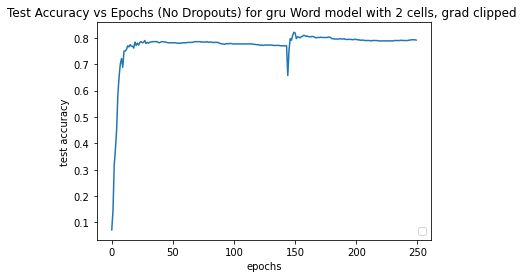

No handles with labels found to put in legend.


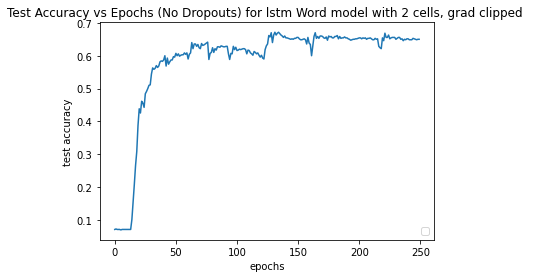

No handles with labels found to put in legend.


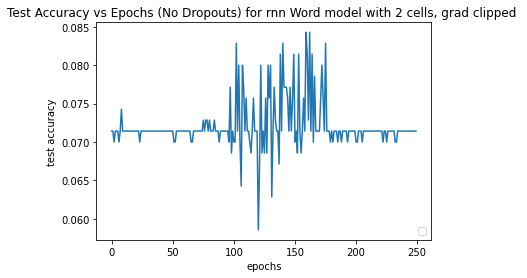

In [13]:
#Plot individuals test acc
for cell_type in cell_type_list:
  pylab.figure()
  pylab.plot(np.arange(no_epochs), test_acc_dict[cell_type])
  pylab.xlabel('epochs')
  pylab.ylabel('test accuracy')
  pylab.title('Test Accuracy vs Epochs (No Dropouts) for %s Word model with %s cells, grad clipped '%(cell_type,cell_num))
  pylab.legend(loc='lower right')
  pylab.show()

No handles with labels found to put in legend.


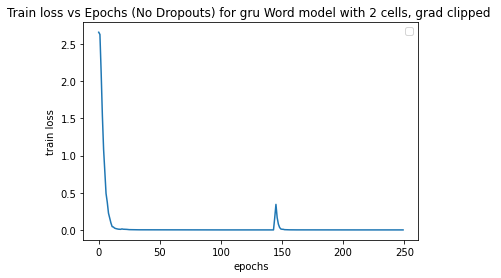

No handles with labels found to put in legend.


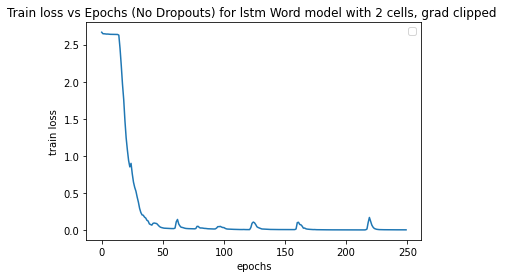

No handles with labels found to put in legend.


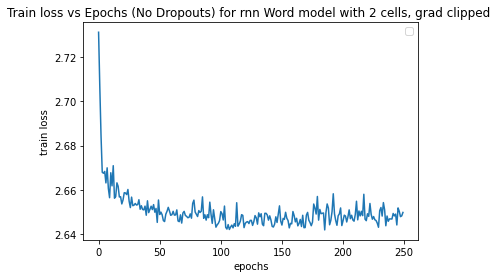

In [14]:
#Plot individual train loss
for cell_type in cell_type_list:
  pylab.figure()
  pylab.plot(np.arange(no_epochs), train_loss_dict[cell_type])
  pylab.xlabel('epochs')
  pylab.ylabel('train loss')
  pylab.title('Train loss vs Epochs (No Dropouts) for %s Word model with %s cells, grad clipped '%(cell_type,cell_num))
  pylab.legend(loc='upper right')
  pylab.show()

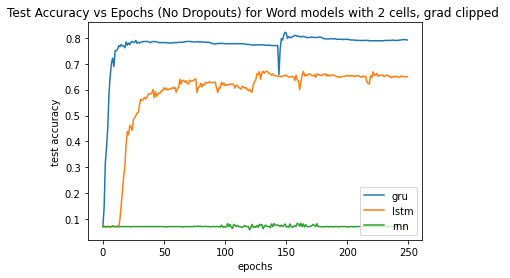

In [15]:
#Plot together test acc
pylab.figure()
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
for cell_type in cell_type_list:
    pylab.plot(np.arange(no_epochs), test_acc_dict[cell_type], label=cell_type)
pylab.title('Test Accuracy vs Epochs (No Dropouts) for Word models with %s cells, grad clipped '%(cell_num))
pylab.legend(loc='lower right')
pylab.show()

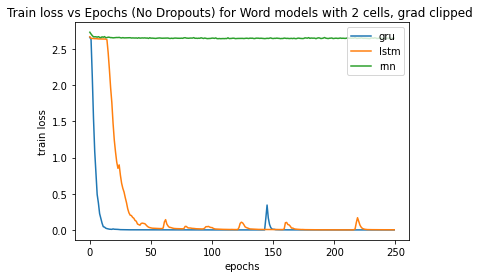

In [16]:
#Plot together train loss
pylab.figure()
for cell_type in cell_type_list:
  pylab.plot(np.arange(no_epochs), train_loss_dict[cell_type],label=cell_type)
pylab.xlabel('epochs')
pylab.ylabel('train loss')
pylab.title('Train loss vs Epochs (No Dropouts) for Word models with %s cells, grad clipped '%(cell_num))
pylab.legend(loc='upper right')
pylab.show()